# Landsat and Sentinel comparison and polygon drill

**Background** Sentinel 2 data is available to access within the a development instance of DEA. In order to access this development environment, you need to set up a configuration file, and point to this when you load `Datacube`. This code assumes that you have already completed this step.

**What does this notebook do?** This notebook allows comparison of Landsat and Sentinel data. Data from Landsat, Sentinel 2a and Sentinel 2b are pulled in for a study area using a polygon to define the import boundaries. This polygon is then applied to the data to mask out pixels from outside of the polygon extent. The user can then select a year for further interrogation. NDVI is calculated from data from all available sensors in the chosen year, and a scatterplot of the mean and standard deviation is plotted up. The user can select a point on the plot to see the corresponding scene as a false colour image.

**Date** March 2018

**Author** Claire Krause

**Required inputs** A shape file containing the polygon you would like to use for the analysis

In [1]:
%pylab notebook
%load_ext autoreload
%autoreload 2
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure
import pandas as pd
from datacube.utils import geometry
import fiona
import rasterio.features
import datetime

# Import widgets for interactive notebook
from ipywidgets import interact, fixed
import ipywidgets as widgets

import sys
import os
sys.path.append(os.path.abspath('/g/data/r78/cek156/dea-notebooks/algorithms'))
import DEAPlotting
import DEADataHandling
import BandIndices

Populating the interactive namespace from numpy and matplotlib


In [2]:
def geometry_mask(geoms, geobox, all_touched=False, invert=False):
    """
    Create a mask from shapes.

    By default, mask is intended for use as a
    numpy mask, where pixels that overlap shapes are False.
    :param list[Geometry] geoms: geometries to be rasterized
    :param datacube.utils.GeoBox geobox:
    :param bool all_touched: If True, all pixels touched by geometries will be burned in. If
                             false, only pixels whose center is within the polygon or that
                             are selected by Bresenham's line algorithm will be burned in.
    :param bool invert: If True, mask will be True for pixels that overlap shapes.
    """
    return rasterio.features.geometry_mask([geom.to_crs(geobox.crs) for geom in geoms],
                                           out_shape=geobox.shape,
                                           transform=geobox.affine,
                                           all_touched=all_touched,
                                           invert=invert)

In [81]:
shape_file = '/g/data/r78/cek156/dea-notebooks/products/Namoi_irr_field.shp'

In [82]:
with fiona.open(shape_file) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

## Set up the extraction query

**Note** We are pulling the data in using their native resolution (Landsat ~25m, Sentinel ~10m), so our data will have different numbers of pixels for the same area.

In [83]:
querys2 = {'output_crs': 'EPSG:3577',
         'resolution': (-10, 10),
         'geopolygon': geom
        }
queryls = {'geopolygon': geom
        }

In [84]:
s2aws = Datacube(config='/home/156/cek156/Sentinel2_datacube.conf')
dc = Datacube(app = 'test')

## First, pull in the data from Sentinel 2a, 2b and Landsat

In [85]:
%%time
AllSensors = ['ls5', 'ls7', 'ls8', 's2a', 's2b']
Alldata = dict()

for Sensor in AllSensors:
    if Sensor[0] == 'l':
        Alldata[Sensor], LScrs, LSaffine = DEADataHandling.load_nbarx(dc, Sensor, queryls, product = 'nbar')
    if Sensor[0] == 's':
        prodname = '{0}_ard_granule'.format(Sensor)
        Alldata[Sensor], S2crs, S2affine = DEADataHandling.load_sentinel(s2aws, prodname, querys2)

loading ls5_nbar_albers
loaded ls5_nbar_albers
making mask ls5_pq_albers
masked ls5_nbar_albers with ls5_pq_albers
loading ls7_nbar_albers
loaded ls7_nbar_albers
making mask ls7_pq_albers
masked ls7_nbar_albers with ls7_pq_albers
loading ls8_nbar_albers
loaded ls8_nbar_albers
making mask ls8_pq_albers
masked ls8_nbar_albers with ls8_pq_albers
loading s2a_ard_granule
loaded s2a_ard_granule
making mask
loading s2b_ard_granule
loaded s2b_ard_granule
making mask
CPU times: user 3min 34s, sys: 1min 18s, total: 4min 52s
Wall time: 17min 49s


In [86]:
for Sensor in Alldata.keys():
    mask = geometry_mask([geom], Alldata[Sensor].geobox, invert=True)
    Alldata[Sensor] = Alldata[Sensor].where(mask)

## Check our polygon has been imported properly

<IPython.core.display.Javascript object>


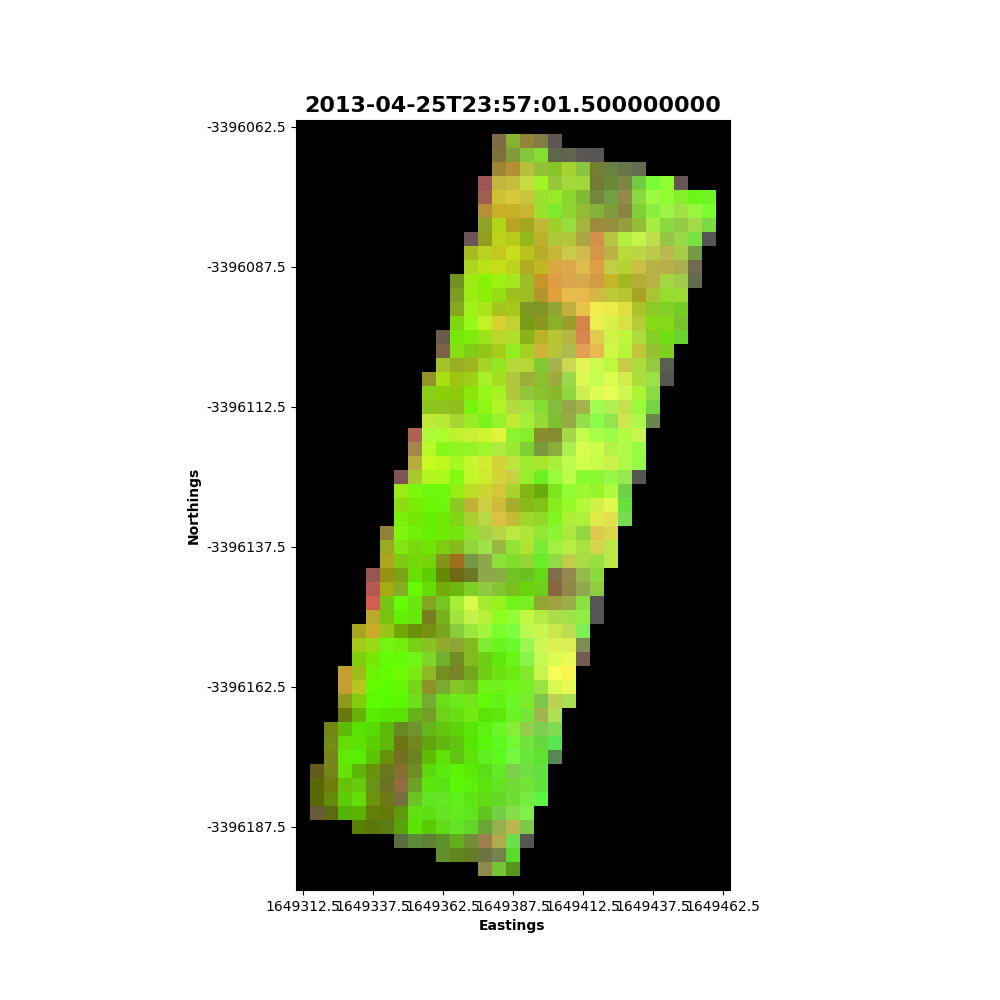

In [87]:
DEAPlotting.three_band_image(Alldata['ls8'], bands = ['swir1', 'nir', 'green'], time = 0)

## Select a year to interrogate further

In [88]:
times = range(1987, 2019)
z = widgets.Dropdown(
    options=times,
    description='Select a year')
display(z)

Dropdown(description='Select a year', options=(1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018), value=1987)

In [99]:
year = z.value
yearslice = ('{0}-01-01'.format(year), '{0}-12-31'.format(year))

Alldataslice = dict()

for Sensor in AllSensors:
    Alldataslice[Sensor] = Alldata[Sensor].sel(time = slice(*yearslice))

## Calculate the Normalised Difference Vegetation Index for each sensor

In [100]:
for Sensor in AllSensors:
    Alldataslice[Sensor]['NDVI'] = BandIndices.calculate_indices(Alldataslice[Sensor], 'NDVI')

The formula we are using is (nir - red)/(nir + red)
The formula we are using is (nir - red)/(nir + red)
The formula we are using is (nir - red)/(nir + red)
The formula we are using is (nir - red)/(nir + red)
The formula we are using is (nir - red)/(nir + red)


## Fix time dimension to be 'day of year'

In [101]:
for Sensor in AllSensors:
    Alldataslice[Sensor]['time'] = ((pd.to_datetime(Alldataslice[Sensor].time.values)) - 
                                    datetime.datetime(year, 1, 1)).days + 1

## Draw up scatter plot of mean of each time step, and select a time to see the satellite image

<IPython.core.display.Javascript object>


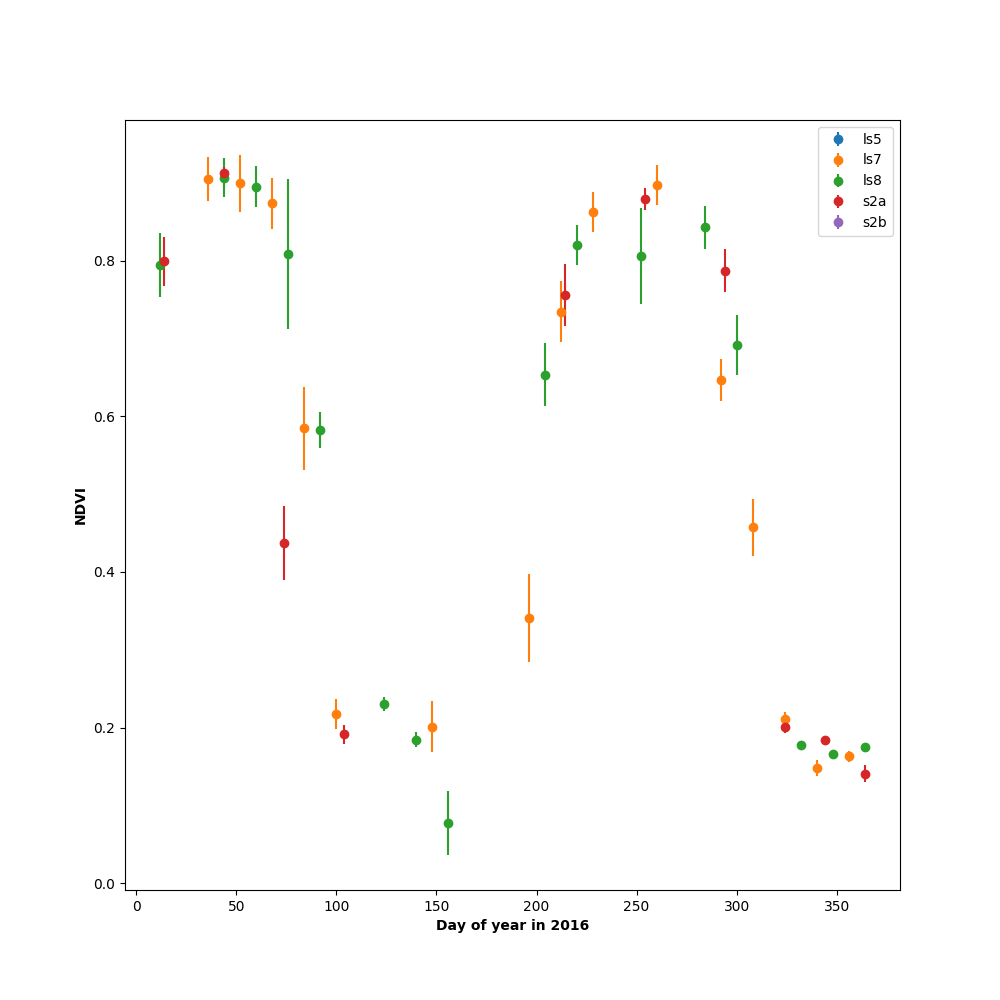

HTML(value='Click on the time you would like to display')

In [106]:
fig = plt.figure(figsize = [10, 10])
for Sensor in AllSensors:
    plt.errorbar(Alldataslice[Sensor].time, Alldataslice[Sensor].NDVI.mean(dim = ('x', 'y')), 
                 Alldataslice[Sensor].NDVI.std(dim = ('x', 'y')), linestyle='None', marker='o')
plt.legend(AllSensors)
plt.xlabel('Day of year in {0}'.format(year), fontweight = 'bold')
plt.ylabel('NDVI', fontweight = 'bold')

w = widgets.HTML("Click on the time you would like to display")
def onclick(event):
    global timeOfInterest
    timeOfInterest = event.xdata
    w.value = 'time of interest : {}'.format(timeOfInterest) 
cid = fig.canvas.mpl_connect('button_press_event', onclick)
display(w)

## Plot up a false colour image for the point selected on the scatter plot

In [103]:
# Manual: Set the sensor that you have selected a point for
Sensor = 'ls8'

<IPython.core.display.Javascript object>


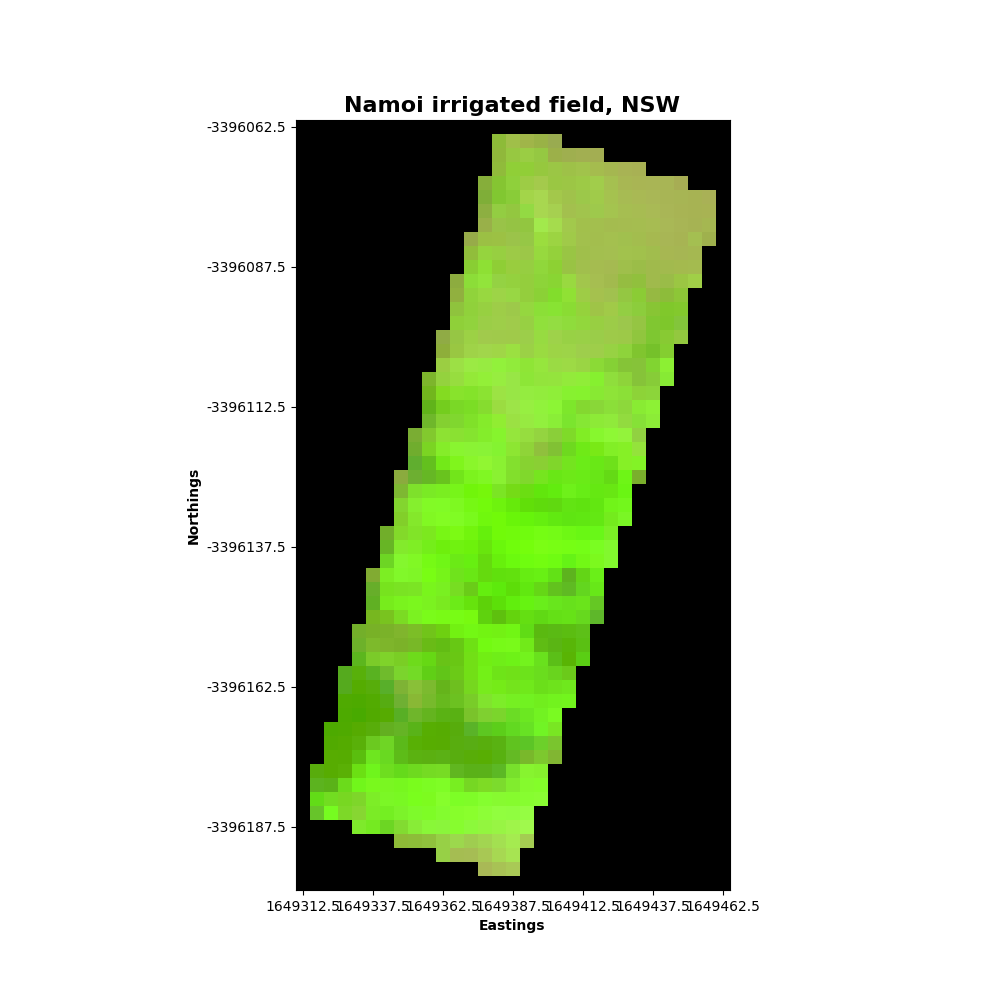

In [105]:
# Manual: if Sentinel is selected, set band name to `nir1`, 
#         if Landsat selected, set band name to `nir`
DEAPlotting.three_band_image(Alldataslice[Sensor].sel(time = np.ceil(timeOfInterest), method = 'nearest'), 
                             bands = ['swir1', 'nir', 'green'], title = 'Namoi irrigated field, NSW')